# Spapros Tutorial: Advanced Selection

This tutorial shows how to select a gene probeset with spapros.  
Next to the basic procedure, we explain several advanced use cases.
Additionally, the parameters are discussed. 

The used dataset contains 3k PBMCs from a healthy donor and is publicly available from
[10x Genomics](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)
[here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz).

You can also derive it from scanpy [here](https://scanpy.readthedocs.io/en/stable/generated/scanpy.datasets.pbmc3k.html#scanpy.datasets.pbmc3k), like we will do in this tutorial.

The preprocessed Anndata consists of log-normalized single cell RNAseq counts of 2638 cells for 13714 genes.

## Contents

0. [Import packages and setup](#Import-packages-and-setup)
1. [Load and preprocess dataset](#Load-and-preprocess-dataset)
2. [Prepare penalties](#Prepare-penalties)
3. [Use cases](#Use-cases)    
    3.1 [Standard selection](#Standard-selection)    
    3.2 [Select few additional genes](#Select-few-additional-genes)    
    3.3 [Cell type classification only](#Cell-type-classification-only)    
    3.4 [Selection with curated marker list](#Selection-with-curated-marker-list)    

## 0. Import packages and setup

To run the notebook locally, create a conda environment using this [environment.yaml](TODO link):

    conda create -f environment.yaml

Then add the conda environment as ipython kernel:

    python -m ipykernel install --user --name spapros --display-name Python (spapros)



In [1]:
import spapros
from spapros import se, ev, pl
from IPython.display import clear_output
import scanpy as sc
import pandas as pd
import os
import yaml
import matplotlib as mpl

In [2]:
sc.settings.verbosity = 0
sc.logging.print_header()
print(f"spapros=={spapros.__version__}")

scanpy==1.8.1 anndata==0.7.8 umap==0.5.2 numpy==1.21.4 scipy==1.7.2 pandas==1.3.4 scikit-learn==1.0.1 statsmodels==0.13.1 python-igraph==0.9.8 pynndescent==0.5.5
spapros==0.1.0


## 1. Load and preprocess dataset

In [3]:
adata = sc.datasets.pbmc3k()
adata_tmp = sc.datasets.pbmc3k_processed()
adata = adata[adata_tmp.obs_names,adata_tmp.var_names]
adata_raw = adata.copy()
sc.pp.normalize_total(adata,target_sum=1e4,key_added="size_factors")
sc.pp.highly_variable_genes(adata,flavor="cell_ranger",n_top_genes=1000)
adata.X = adata_raw.X
sc.pp.log1p(adata)
adata.obs['celltype'] = adata_tmp.obs['louvain']
adata

/home/st/strasserl/anaconda3/envs/spapros/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'size_factors', 'celltype'
    var: 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

## 2. Prepare penalties

In [4]:
# TODO

## 3. Use cases: 

We will go through some uses cases for gene selection, starting with the basic procedure.

### 3.1. Standard selection

#### a. Set up the ProbesetSelector


In [5]:
# create an instance of the ProbesetSelector class
selector = se.ProbesetSelector(adata, 
                            n=50, 
                            celltype_key="celltype", 
                            verbosity=1, 
                            save_dir=None)

The following celltypes' test set sizes for forest training are below min_test_n (=20):
	 Dendritic cells : 9
	 Megakaryocytes  : 3


TODO  
parameter discussion   
interesting pararms could be:   

```
general: 
    prior_genes: 
    preselected_genes: 
        Pre selected genes (these will also have the highest ranking in the final list).

marker: 
    marker_corr_th
    n_list_markers
        n_list_markers: 
        Minimal number of markers per celltype that are at least selected. Selected means either selecting genes
        from the marker list or having correlated genes in the already selected panel. (Set the correlation
        threshold with marker_selection_hparams['penalty_threshold']).
        If you want to select a different number of markers for celltypes in adata and celltypes only in the marker
        list, set e.g.: n_list_markers = {'adata_celltypes':2,'list_celltypes':3}

penalties:
    m_penalties_adata_celltypes
    m_penalties_list_celltypes
    min_mean_difference:
        Minimal difference of mean expression between at least one celltype and the background. In this test only
        cell types from `celltypes` are taken into account (also for the background). This minimal difference is
        applied as an additional binary penalty in pca_penalties, DE_penalties and m_penalties_adata_celltypes.
    pca_penalties
    DE_penalties
    marker penalties

```



#### b. Start the selection

In [6]:
# TODO
# rough description of the spapros selection pipeline

In [7]:
selector.select_probeset()


Output()

Select pca genes...
Select genes based on differential expression and forests as baseline for the final forests...


Train hierarchical trees:   0%|          | 0/3 [00:00<?, ?it/s]

Add DE genes with specific reference groups to improve tree performance...


Train hierarchical trees:   0%|          | 0/3 [00:00<?, ?it/s]

Train hierarchical trees:   0%|          | 0/3 [00:00<?, ?it/s]

Train hierarchical trees:   0%|          | 0/3 [00:00<?, ?it/s]

Train hierarchical trees:   0%|          | 0/3 [00:00<?, ?it/s]

Train final forests by adding genes from the DE_baseline forest for celltypes with low performance...


Train hierarchical trees:   0%|          | 0/3 [00:00<?, ?it/s]

	 Finished...


The selected probeset can be examined like this: 

In [8]:
selector.probeset

,gene_nr,selection,rank,marker_rank,tree_rank,importance_score,pca_score,pre_selected,prior_selected,pca_selected,celltypes_DE_1vsall,celltypes_DE_specific,celltypes_DE,celltypes_marker,list_only_ct_marker,required_marker,required_list_marker
PPBP,1,True,1.0,1.0,1.0,1.000000,1.964765,False,False,True,Megakaryocytes,,Megakaryocytes,Megakaryocytes,False,True,False
HLA-DQA1,2,True,1.0,1.0,1.0,0.613524,0.791760,False,False,True,,Dendritic cells,Dendritic cells,Dendritic cells,False,True,False
FCGR3A,3,True,1.0,1.0,1.0,0.570825,1.281816,False,False,True,,FCGR3A+ Monocytes,FCGR3A+ Monocytes,FCGR3A+ Monocytes,False,True,False
GZMB,4,True,1.0,1.0,1.0,0.511744,2.418087,False,False,True,NK cells,,NK cells,NK cells,False,True,False
CD79A,5,True,1.0,1.0,1.0,0.441937,2.076160,False,False,True,B cells,,B cells,B cells,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RP11-314N13.3,996,False,NaN,NaN,NaN,NaN,0.001506,False,False,False,,,,,False,False,False
RP11-950C14.3,997,False,NaN,NaN,NaN,NaN,0.001313,False,False,False,,,,,False,False,False
CCDC122,998,False,NaN,NaN,NaN,NaN,0.001274,False,False,False,,,,,False,False,False
TACR2,999,False,NaN,NaN,NaN,NaN,0.001100,False,False,False,,,,,False,False,False


#### c. Vizualize the results

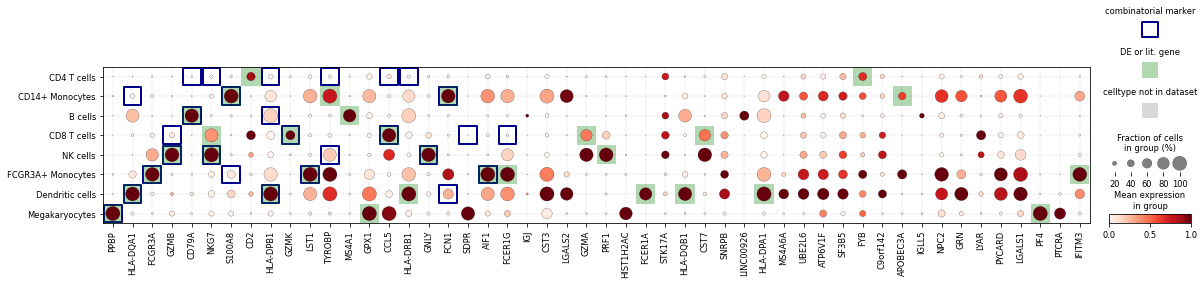

In [9]:
pl.masked_dotplot(adata, selector)

## Select reference gene sets

With the method `select_reference_probesets` you can easily select reference probesets.
By default, 4 sets are created: 

- `pca_selection`: PCA based selection
- `hvg_selection`: Selection of highly variable genes
- `de_selection`: Differentially expressed genes selection
- `random_selection`: Random gene selection

The selection methods can be altered with the parameter `reference_selections`. 
It takes a dictionary, where the keys are the wanted selection method names and the values are their hyper parameters. 

An easy way to select several random gene sets is provided by the parameter `seeds`, which takes a list of seeds. Each list entry is used as seed for one random gene set selection. 

In [10]:
reference_sets = se.select_reference_probesets(adata, 50)

Select reference hvg_selection genes...
	 ...finished.
Select reference random_selection genes...
	 ...finished.
Select reference pca_selection genes...
	 ...finished.
Select reference DE_selection genes...
	 ...finished.


### 3.2 Select a few additional genes

In [11]:
# TODO 

### 3.3 Cell type classification only

In [12]:
# TODO

### 3.4 Selection with curated marker list

In [13]:
# TODO

## What's next? 

After selecting probesets, they should be evaluated.  
See our [basic evaluation tutorial](https://spapros.readthedocs.io/en/latest/tutorials/spapros_tutorial_basic_evaluation.html) or our [advanced evaluation tutorial](https://spapros.readthedocs.io/en/latest/tutorials/spapros_tutorial_advanced_evaluation.html) for detailed instructions.